# 가중치 초기화

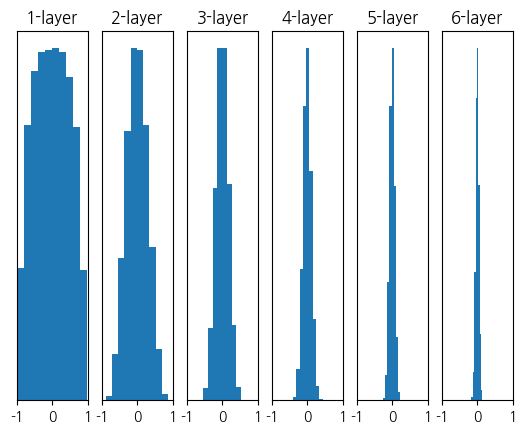

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False

dims = [4096] * 7
hs = []
x = np.random.randn(16, dims[0])
for D_in, D_out in zip(dims[:-1], dims[1:]):
    W = 0.01 * np.random.randn(D_in, D_out)
    x = np.tanh(x.dot(W))
    hs.append(x)

for i, a in enumerate(hs):
    plt.subplot(1, len(hs), i+1)
    plt.title(str(i+1)+'-layer')
    plt.hist(a.flatten())
    plt.gca().axes.yaxis.set_visible(False)#y범위 없애기
    plt.xlim(-1,1)

plt.show()

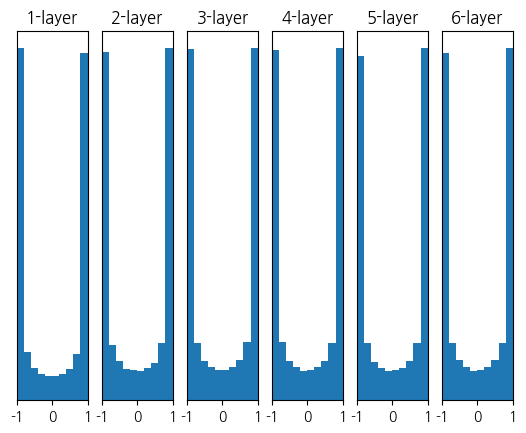

In [4]:
dims = [4096] * 7
hs = []
x = np.random.randn(16, dims[0])
for D_in, D_out in zip(dims[:-1], dims[1:]):
    W = 0.05 * np.random.randn(D_in, D_out)
    x = np.tanh(x.dot(W))
    hs.append(x)

for i, a in enumerate(hs):
    plt.subplot(1, len(hs), i+1)
    plt.title(str(i+1)+'-layer')
    plt.hist(a.flatten())
    plt.gca().axes.yaxis.set_visible(False)#y범위 없애기
    plt.xlim(-1,1)
plt.show()

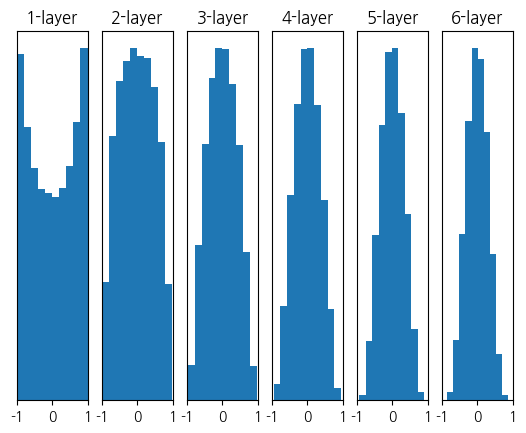

In [5]:
# Xavier initialization
dims = [4096] * 7
hs = []
x = np.random.randn(16, dims[0])
for D_in, D_out in zip(dims[:-1], dims[1:]):
    W = np.random.randn(D_in, D_out) / np.sqrt(D_in)
    x = np.tanh(x.dot(W))
    hs.append(x)

for i, a in enumerate(hs):
    plt.subplot(1, len(hs), i+1)
    plt.title(str(i+1)+'-layer')
    plt.hist(a.flatten())
    plt.gca().axes.yaxis.set_visible(False)#y범위 없애기
    plt.xlim(-1,1)
plt.show()

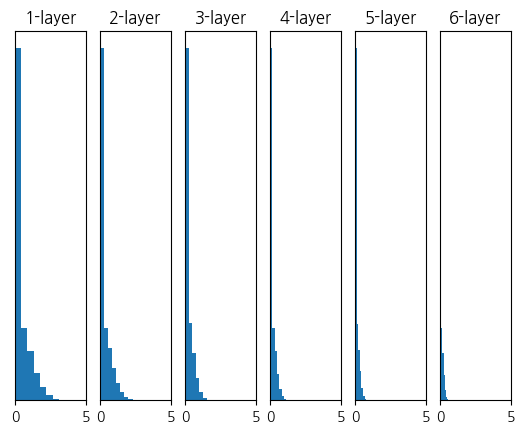

In [6]:
# Xavier initialization을 ReLU에 적용했을 때
def relu(x):
    return np.maximum(x, 0)

dims = [4096] * 7
hs = []
x = np.random.randn(16, dims[0])
for D_in, D_out in zip(dims[:-1], dims[1:]):
    W = np.random.randn(D_in, D_out)/np.sqrt(D_in)
    x = relu(x.dot(W))
    hs.append(x)

for i, a in enumerate(hs):
    plt.subplot(1, len(hs), i+1)
    plt.title(str(i+1)+'-layer')
    plt.hist(a.flatten())
    plt.gca().axes.yaxis.set_visible(False)#y범위 없애기
    plt.xlim(0,5)
plt.show()

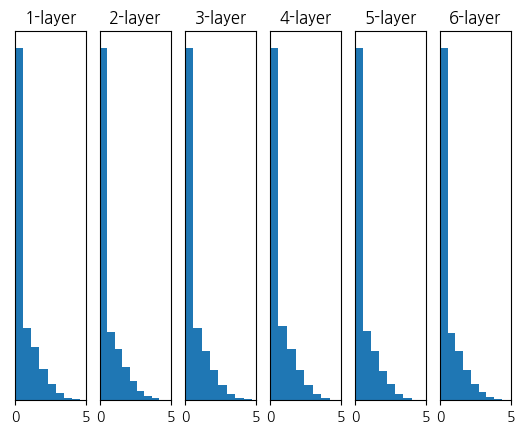

In [7]:
# He initialization

def relu(x):
    return np.maximum(x, 0)

dims = [4096] * 7
hs = []
x = np.random.randn(16, dims[0])
for D_in, D_out in zip(dims[:-1], dims[1:]):
    W = np.random.randn(D_in, D_out)*(np.sqrt(2/D_in))
    x = relu(x.dot(W))
    hs.append(x)

for i, a in enumerate(hs):
    plt.subplot(1, len(hs), i+1)
    plt.title(str(i+1)+'-layer')
    plt.hist(a.flatten())
    plt.gca().axes.yaxis.set_visible(False)#y범위 없애기
    plt.xlim(0,5)
plt.show()

## Augmentation 적용

In [1]:
# Back Translation
import googletrans
translator = googletrans.Translator()

def trans(text, istoENG=True):
    if istoENG == True:
        return translator.translate(text, dest='en').text
    else:
        return translator.translate(text, dest='ko').text

# KorEDA
import sys
sys.path.append('C:/Users/Myeong/dding/import_module')

import koreda

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.optimizers import SGD, Adagrad, Adam, RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from soynlp.tokenizer import LTokenizer
from soynlp.word import WordExtractor
import tensorflow as tf
import random

# 데이터 불러오기
data_path = 'C:/Users/Myeong/dding/data/train_1000_mk2.csv'
data = pd.read_csv(data_path)

# SOYNLP 토크나이저 학습
sentences = data.non_label_sentence
sentences = [sen for sen in sentences]

word_extractor = WordExtractor(
    min_frequency=100, # example
    min_cohesion_forward=0.05,
    min_right_branching_entropy=0.0
)

word_extractor.train(sentences)
words = word_extractor.extract()

cohesion_score = {word:score.cohesion_forward for word, score in words.items()}
tokenizer = LTokenizer(scores=cohesion_score)

# 토큰화
data['tokenized'] = data['non_label_sentence'].apply(tokenizer.tokenize)

conversation = data['tokenized'].values

# 토큰화 된 문장 정수 인코딩 진행
vocab_size = 30000
tokenizer_tf = Tokenizer(num_words=vocab_size) 
tokenizer_tf.fit_on_texts(conversation)
'''
===============================================================================================
===============================================================================================
'''    
# split train, validation, test function
def split_data(data, train_size=0.9):
    num_train = int(len(data) * 0.9)
    
    train_data = data.iloc[:num_train,:]
    valid_data = data.iloc[num_train:, :]

    valid_x = tokenizer_tf.texts_to_sequences(valid_data['tokenized'].values)

    valid_x = pad_sequences(valid_x)

    valid_label = valid_data['class']
    valid_y = valid_label.apply(lambda x : labels[x])

    return train_data, valid_x, valid_y

# 배치를 받아서 Augmentation이후 리턴해주는 함수
def random_aug(data):
    class_list = ['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화', '일반 대화']
    aug_text = []
    for i in class_list:
        sample_text = list(data[data['class']==i]['non_label_sentence'].values)
        augmentation = []
        for t in sample_text:
            aug = koreda.EDA(t, num_aug=1)
            augmentation += aug

        bt_candidate = random.choice(sample_text)
        ko2en = trans(bt_candidate)
        en2ko = trans(ko2en, False)
        augmentation.append(en2ko)

        for j in augmentation:
            aug_text.append([j, i])
    aug_data = pd.DataFrame(aug_text, columns=['text', 'class'])
    
    # Augmentation된 데이터 토큰화
    aug_data['tokenized'] = aug_data['text'].apply(tokenizer.tokenize)
    encoded_data = tokenizer_tf.texts_to_sequences(aug_data['tokenized'].values)
    encoded_x = pad_sequences(encoded_data)
    
    label = aug_data['class']
    encoded_y = label.apply(lambda x : labels[x])
    return encoded_x, encoded_y
'''
===============================================================================================
===============================================================================================
'''    
# X_data = tokenizer_tf.texts_to_sequences(conversation)

# # 패딩 진행
# padded = pad_sequences(X_data)
# train_data = padded

# 라벨 인코딩
labels = {'협박 대화':0, '갈취 대화':1, '직장 내 괴롭힘 대화':2, '기타 괴롭힘 대화':3, '일반 대화':4}

# train_label = data['class']
# train_label = train_label.apply(lambda x: labels[x])

# # 데이터 나누기
# train_X, test_X, train_Y, test_Y = train_test_split(train_data, train_label, test_size=0.4, random_state=22, stratify=train_label)
# valid_X, test_X, valid_Y, test_Y = train_test_split(test_X, test_Y, test_size=0.5, random_state=22, stratify=test_Y)

training was done. used memory 0.440 Gbry 0.366 Gb
all cohesion probabilities was computed. # words = 868
all branching entropies was computed # words = 23278
all accessor variety was computed # words = 23278


In [3]:
# 모델 생성

embedding_dim = 128
hidden_units = 64
label_size = len(labels)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, embedding_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(hidden_units, kernel_regularizer='l2', recurrent_dropout=0.3, return_sequences=True))
model.add(tf.keras.layers.LSTM(hidden_units, kernel_regularizer='l2', recurrent_dropout=0.3))

model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(label_size))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         3840000   
                                                                 
 lstm (LSTM)                 (None, None, 64)          49408     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 165       
                                                                 
Total params: 3,924,677
Trainable params: 3,924,677
Non-

In [4]:
# 손실, 최적화 함수, 훈련, 검증 함수 정의

cce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(2e-4)
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = cce(y, logits)

    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_acc_metric.update_state(y, logits)

    return loss_value 

@tf.function
def test_step(x, y):
    val_logits = model(x, training=False)
    val_loss = cce(y, val_logits)
    val_acc_metric.update_state(y, val_logits)
    
    return val_loss

In [5]:
# 훈련 시작
from tqdm import tqdm

train_data, valid_x, valid_y = split_data(data)
# train_x, train_y = random_aug(train_data)

steps_per_epoch = len(train_data) // 15
batch_size = len(valid_x) // steps_per_epoch

val_dataset = tf.data.Dataset.from_tensor_slices((valid_x, valid_y))
val_dataset = val_dataset.batch(batch_size, drop_remainder=True)

epochs=50
history = {'loss':[], 'val_loss':[], 'acc':[], 'val_acc':[]}

min_val_loss = 999
val_monitor = 0
for epoch in range(1, epochs+1):
    print("\nStart of epoch %d" % (epoch))
    
    for step in tqdm(range(steps_per_epoch)):
        train_x, train_y = random_aug(train_data.sample(15))
        loss_value = train_step(train_x, train_y)
        val_loss_value = test_step(valid_x, valid_y)
        
        if step % 20 == 0:
            history['loss'].append(loss_value.numpy())
            history['val_loss'].append(val_loss_value.numpy())
    
    # validation loss에 변화가 없고 오히려 증가한다면 조기종료
    if val_loss_value <= min_val_loss:
        min_val_loss = val_loss_value
    elif val_loss_value > min_val_loss:
        val_monitor += 1

    if val_monitor >= 10:
        history['acc'].append(train_acc.numpy())
        history['val_acc'].append(val_acc.numpy())
        print('Training acc over epoch: %.4f'% (float(train_acc)))
        print('Validation acc: %.4f'% (float(val_acc)))
        print('Early Stopped')
        break
    
    train_acc = train_acc_metric.result()
    val_acc = val_acc_metric.result()

    history['acc'].append(train_acc.numpy())
    history['val_acc'].append(val_acc.numpy())
    print('Training acc over epoch: %.4f'% (float(train_acc)))
    print('Validation acc: %.4f'% (float(val_acc)))

    # 에폭마다 훈련 accuracy metric 초기화
    train_acc_metric.reset_states()
    val_acc_metric.reset_states()


Start of epoch 1


  1%|▏         | 4/292 [00:10<11:45,  2.45s/it]

  2%|▏         | 5/292 [00:12<11:00,  2.30s/it]

100%|██████████| 292/292 [06:10<00:00,  1.27s/it]


Training acc over epoch: 0.3515
Validation acc: 0.2175

Start of epoch 2


100%|██████████| 292/292 [04:31<00:00,  1.08it/s]


Training acc over epoch: 0.6299
Validation acc: 0.5126

Start of epoch 3


100%|██████████| 292/292 [04:16<00:00,  1.14it/s]


Training acc over epoch: 0.7500
Validation acc: 0.6561

Start of epoch 4


100%|██████████| 292/292 [04:24<00:00,  1.10it/s]


Training acc over epoch: 0.8511
Validation acc: 0.7300

Start of epoch 5


100%|██████████| 292/292 [04:25<00:00,  1.10it/s]


Training acc over epoch: 0.9305
Validation acc: 0.7523

Start of epoch 6


100%|██████████| 292/292 [04:19<00:00,  1.12it/s]


Training acc over epoch: 0.9575
Validation acc: 0.7759

Start of epoch 7


100%|██████████| 292/292 [04:15<00:00,  1.14it/s]


Training acc over epoch: 0.9594
Validation acc: 0.7718

Start of epoch 8


100%|██████████| 292/292 [04:07<00:00,  1.18it/s]


Training acc over epoch: 0.9767
Validation acc: 0.7700

Start of epoch 9


100%|██████████| 292/292 [04:08<00:00,  1.18it/s]


Training acc over epoch: 0.9774
Validation acc: 0.7771

Start of epoch 10


100%|██████████| 292/292 [04:14<00:00,  1.15it/s]


Training acc over epoch: 0.9814
Validation acc: 0.7826

Start of epoch 11


100%|██████████| 292/292 [04:14<00:00,  1.15it/s]


Training acc over epoch: 0.9834
Validation acc: 0.7839

Start of epoch 12


100%|██████████| 292/292 [04:18<00:00,  1.13it/s]


Training acc over epoch: 0.9897
Validation acc: 0.7870

Start of epoch 13


100%|██████████| 292/292 [04:16<00:00,  1.14it/s]


Training acc over epoch: 0.9911
Validation acc: 0.7855

Start of epoch 14


100%|██████████| 292/292 [04:18<00:00,  1.13it/s]

Training acc over epoch: 0.9911
Validation acc: 0.7855
Early Stopped


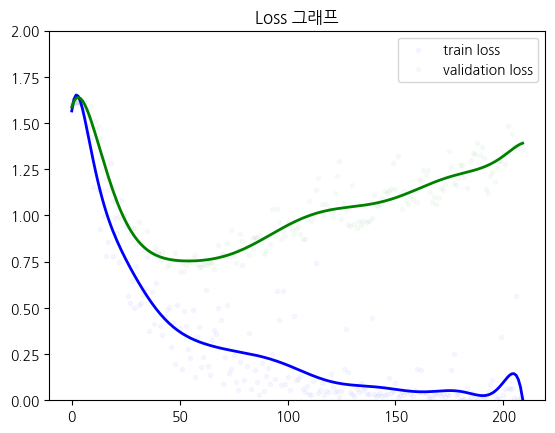

In [8]:
# loss 시각화
tr_range = list(range(len(history['loss'])))

fig, ax = plt.subplots()
_ = ax.scatter(tr_range, history['loss'], s=3**2, c='b', alpha=0.03)
_ = ax.scatter(tr_range, history['val_loss'], s=3**2, c='g', alpha=0.03)

t_d = np.polyfit(tr_range, history['loss'], 15)
t_p = np.poly1d(t_d)
plt.plot(tr_range, t_p(tr_range), 'b', linewidth=2)

v_d = np.polyfit(tr_range, history['val_loss'], 10)
v_p = np.poly1d(v_d)
plt.plot(tr_range, v_p(tr_range), 'g', linewidth=2)
plt.title('Loss 그래프')
plt.ylim([0,2])
plt.legend(['train loss', 'validation loss'])
plt.show()

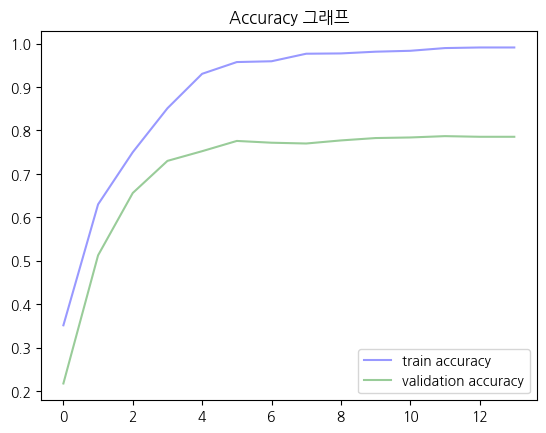

In [9]:
# Accuracy 시각화
tr_range = list(range(len(history['acc'])))

fig, ax = plt.subplots()
_ = ax.plot(tr_range, history['acc'], c='b', alpha=0.4)
_ = ax.plot(tr_range, history['val_acc'], c='g', alpha=0.4)

plt.title('Accuracy 그래프')
plt.legend(['train accuracy', 'validation accuracy'])
plt.show()

In [38]:
# KorEDA
import sys
import pickle
import random
sys.path.append('C:/Users/Myeong/dding/import_module')

wordnet = {}
with open("C:/Users/Myeong/dding/import_module/wordnet.pickle", "rb") as f:
	wordnet = pickle.load(f)

def get_synonyms(word):
	synomyms = []

	try:
		for syn in wordnet[word]:
			synomyms.append(syn)
	except:
		pass

	return synomyms

def synonym_replacement(words, n):
	new_words = words.copy()
	random_word_list = list(set([word for word in words]))
	random.shuffle(random_word_list)
	num_replaced = 0
	for random_word in random_word_list:
		synonyms = get_synonyms(random_word)
		if len(synonyms) >= 1:
			synonym = random.choice(list(synonyms))
			new_words = [synonym if word == random_word else word for word in new_words]
			num_replaced += 1
		if num_replaced >= n:
			break

	if len(new_words) != 0:
		sentence = ' '.join(new_words)
		new_words = sentence.split(" ")

	else:
		new_words = ""

	return new_words

def synonym_replacement_sentence(sentence, n=1):
	new_words = sentence.split(' ')
	random_word_list = list(set([word for word in new_words]))
	random.shuffle(random_word_list)
	num_replaced = 0
	for random_word in random_word_list:
		synonyms = get_synonyms(random_word)
		if len(synonyms) >= 1:
			synonym = random.choice(list(synonyms))
			new_words = [synonym if word == random_word else word for word in new_words]
			num_replaced += 1
		if num_replaced >= n:
			break

	if len(new_words) != 0:
		new_sentence = ' '.join(new_words)

	else:
		new_sentence = ""

	return new_sentence

synonym_replacement(['나비'],1)

['나비']

In [50]:
import gensim
import pandas as pd
from konlpy.tag import Okt
import random

model = gensim.models.Word2Vec.load('C:/Users/Myeong/dding/data/ko.bin')
okt = Okt()

def random_insertion(sen):
    noun = []
    origin = okt.morphs(sen)
    tokens = okt.pos(sen, stem=True, norm=True)
    for word in tokens:
        if word[1] in ['Noun']:
            noun.append(word[0])

    simi = []
    for n in noun:
        try:
            simi.append(model.most_similar(n)[0][0])
        except:
            continue

    ran_idx = random.randint(0,len(origin))

    for s in simi:
        origin.insert(ran_idx, s)

    return ' '.join(origin)

AttributeError: 'Word2Vec' object has no attribute 'wv'

In [51]:
# Back Translation
import googletrans
translator = googletrans.Translator()

def trans(text, istoENG=True):
    if istoENG == True:
        return translator.translate(text, dest='en').text
    else:
        return translator.translate(text, dest='ko').text

In [52]:
trans('진짜 이거 밖에 없어요')

'I really only have this'

In [53]:
trans('I really only have this', False)

'정말 이것밖에 없어요'